In [1]:
coordination_source = """
{name:'兰州', geoCoord:[103.73, 36.03]},
{name:'嘉峪关', geoCoord:[98.17, 39.47]},
{name:'西宁', geoCoord:[101.74, 36.56]},
{name:'成都', geoCoord:[104.06, 30.67]},
{name:'石家庄', geoCoord:[114.48, 38.03]},
{name:'拉萨', geoCoord:[102.73, 25.04]},
{name:'贵阳', geoCoord:[106.71, 26.57]},
{name:'武汉', geoCoord:[114.31, 30.52]},
{name:'郑州', geoCoord:[113.65, 34.76]},
{name:'济南', geoCoord:[117, 36.65]},
{name:'南京', geoCoord:[118.78, 32.04]},
{name:'合肥', geoCoord:[117.27, 31.86]},
{name:'杭州', geoCoord:[120.19, 30.26]},
{name:'南昌', geoCoord:[115.89, 28.68]},
{name:'福州', geoCoord:[119.3, 26.08]},
{name:'广州', geoCoord:[113.23, 23.16]},
{name:'长沙', geoCoord:[113, 28.21]},
//{name:'海口', geoCoord:[110.35, 20.02]},
{name:'沈阳', geoCoord:[123.38, 41.8]},
{name:'长春', geoCoord:[125.35, 43.88]},
{name:'哈尔滨', geoCoord:[126.63, 45.75]},
{name:'太原', geoCoord:[112.53, 37.87]},
{name:'西安', geoCoord:[108.95, 34.27]},
//{name:'台湾', geoCoord:[121.30, 25.03]},
{name:'北京', geoCoord:[116.46, 39.92]},
{name:'上海', geoCoord:[121.48, 31.22]},
{name:'重庆', geoCoord:[106.54, 29.59]},
{name:'天津', geoCoord:[117.2, 39.13]},
{name:'呼和浩特', geoCoord:[111.65, 40.82]},
{name:'南宁', geoCoord:[108.33, 22.84]},
//{name:'西藏', geoCoord:[91.11, 29.97]},
{name:'银川', geoCoord:[106.27, 38.47]},
{name:'乌鲁木齐', geoCoord:[87.68, 43.77]},
{name:'香港', geoCoord:[114.17, 22.28]},
{name:'澳门', geoCoord:[113.54, 22.19]}
"""

In [2]:
import re

city_information = {}

for line in coordination_source.split('\n'):
    if not line.strip() or line.startswith('//'): 
        continue
    
    city = re.findall("name:'(\w+)'", line)[0]
    pos = re.findall("Coord:\[(\d+.\d+),\s(\d+.\d+)\]",line)[0]
    pos = tuple(map(float, pos))
    city_information[city] = pos

In [3]:
import math

In [4]:
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [5]:
def get_city_distance(city1, city2):
    return geo_distance(city_information[city1], city_information[city2])

In [6]:
import networkx as nx

In [7]:
cities = list(city_information.keys())
city_graph = nx.Graph()
city_graph.add_nodes_from(cities)

In [8]:
nx.draw(city_graph, city_information, with_labels=True, node_size=2)

In [9]:
from collections import defaultdict

In [10]:
threshold = 700

cities_connection = defaultdict(list)

for c1 in cities:
    for c2 in cities:
        if c1 == c2:
            continue
        if get_city_distance(c1, c2) < threshold:
            cities_connection[c1].append(c2)

In [11]:
cities_connection_graph = nx.Graph(cities_connection)

/Users/xincj/.virtualenvs/python3env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


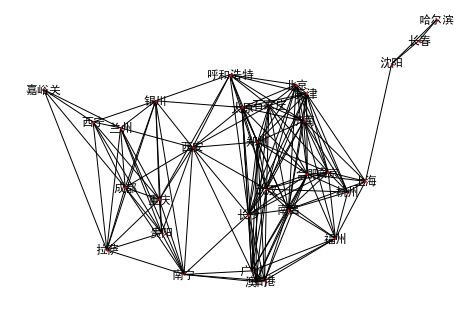

In [12]:
nx.draw(cities_connection_graph, city_information, with_labels=True, node_size=2)

In [13]:
def search(graph, start, is_goal, strategy_func, get_successors):
    pathes = [[start]]
    seen = set()
    while pathes:
        path = pathes.pop(0)
        frontier = path[-1]
        if frontier in seen:
            continue
        
        for city in get_successors(frontier, graph):
            if city in path:
                continue
            new_path = path + [city]
            pathes.append(new_path)
            if is_goal(city):
                return new_path
        
        pathes = strategy_func(pathes)
        seen.add(frontier)
    return []

In [14]:
def get_successors(frontier, graph):
    return graph[frontier]

In [15]:
def is_goal(node, destination):
    return node == destination

In [16]:
def get_path_distance(path):
    distance = 0
    for i in range(len(path)):
        if i == 0:
            continue
        distance += get_city_distance(path[i - 1], path[i])
    return distance
    

In [17]:
def min_distance(pathes):
    return sorted(pathes, key=lambda p: get_path_distance(p))

In [18]:
from functools import partial

In [19]:
def exact_destination_search(graph, start, dest, strategy_func, get_successors):
    def is_goal_inner(node):
        return node == dest
    return search(graph, start, is_goal_inner, strategy_func, get_successors)

In [20]:
min_distance_search = partial(exact_destination_search, strategy_func=min_distance, get_successors=get_successors)

In [21]:
min_distance_search(cities_connection_graph, '北京', '拉萨')

['北京', '呼和浩特', '银川', '拉萨']

In [22]:
def min_change_station(pathes):
    return sorted(pathes, key=lambda p: len(p))

In [24]:
min_change_search = partial(exact_destination_search, strategy_func=min_change_station, get_successors=get_successors)

In [26]:
min_change_search(cities_connection_graph, '上海', '西宁')

['上海', '济南', '太原', '银川', '西宁']

In [27]:
min_distance_search(cities_connection_graph, '上海', '西宁')

['上海', '南京', '郑州', '西安', '重庆', '西宁']